## Notebook to understand working with wavefront objects in and out of SRW

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, time
from copy import deepcopy
import math
import numpy as np
# import srwlib


# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser
from rslaser.optics import wavefront

import scipy

# SRW and srwlib (the corresponding Python API) are pre-installed on Sirepo/Jupyter
import srwlib
from srwlib import srwl
from srwlib import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
hfontMed = {'fontname':'Latin Modern Roman', 'size' : 19, 'weight' : 'bold'}
hfontLarge = {'fontname':'Latin Modern Roman', 'size' : 24, 'weight' : 'bold'}

In [2]:
def createGsnSrcSRW02(sigx, sigy, dist_waist, pulseE, poltype, nx = 400, ny = 400, phE=10e3, mx = 0, my = 0):
    """
    This function calculates a Gsn wavefront with waist at zero meters
    and allows calculation at any longitudinal point via dist_waist.
    Args:
        sigx: horizontal beam size at waist [m]
        sigy: vertical beam size at waist [m]
        dist_waist: distance of Gsn from waist [m]
        pulseE: energy per pulse [J]
        poltype: polarization type (0=linear horizontal, 1=linear vertical, 2=linear 45 deg, 3=linear 135 deg, 4=circular right, 5=circular left, 6=total)
        nx = no. of horizontal mesh points
        ny = no. of vertical mesh points
        phE: photon energy [eV]
        mx = horizontal Hermite mode
        my = vertical Hermite mode

    Returns:
        wfr
    """

    constConvRad = 1.23984186e-06/(4*3.1415926536)  ##conversion from energy to 1/wavelength
    rmsAngDiv_x = constConvRad/(phE*sigx)             ##RMS angular divergence [rad]
    rmsAngDiv_y = constConvRad/(phE*sigy)
    sigrL_x = math.sqrt(sigx**2+(dist_waist*rmsAngDiv_x)**2)  ##required RMS size to produce requested RMS beam size after propagation by propLen
    sigrL_y = math.sqrt(sigy**2+(dist_waist*rmsAngDiv_y)**2)
    # sigrL=math.sqrt(sigrW**2+(propLen*rmsAngDiv)**2)

    #***********Gaussian Beam Source
    GsnBm = SRWLGsnBm() #Gaussian Beam structure (just parameters)
    GsnBm.x = 0 #Transverse Positions of Gaussian Beam Center at Waist [m]
    GsnBm.y = 0
    GsnBm.z = 0.0 # Longitudinal Position of Waist [m]
    GsnBm.xp = 0 # Average Angles of Gaussian Beam at Waist [rad]
    GsnBm.yp = 0
    GsnBm.avgPhotEn = phE # Photon Energy [eV]
    GsnBm.pulseEn = pulseE # Energy per Pulse [J] - to be corrected
    GsnBm.repRate = 1 # Rep. Rate [Hz] - to be corrected
    GsnBm.polar = poltype # 1- linear horizontal?
    GsnBm.sigX = sigx # Horiz. RMS size at Waist [m]
    GsnBm.sigY = sigy # Vert. RMS size at Waist [m]

    GsnBm.sigT = 10e-15 #Pulse duration [s] (not used?)
    GsnBm.mx = mx #Transverse Gauss-Hermite Mode Orders
    GsnBm.my = my

    #***********Initial Wavefront
    # create mesh
    wfr = SRWLWfr() #Initial Electric Field Wavefront
    wfr.allocate(1, nx, ny) #Numbers of points vs Photon Energy (1), Horizontal and Vertical Positions (dummy)
    wfr.mesh.zStart = dist_waist #Longitudinal Position [m] at which initial Electric Field has to be calculated, i.e. the position of the first optical element
    wfr.mesh.eStart = GsnBm.avgPhotEn #Initial Photon Energy [eV]
    wfr.mesh.eFin = GsnBm.avgPhotEn #Final Photon Energy [eV]

    wfr.unitElFld = 1 # Electric field units: 0- arbitrary, 1- sqrt(Phot/s/0.1%bw/mm^2), 2- sqrt(J/eV/mm^2) or sqrt(W/mm^2), depending on representation (freq. or time)

    distSrc = wfr.mesh.zStart - GsnBm.z
    # Horizontal and Vertical Position Range for the Initial Wavefront calculation
    # can be used to simulate the First Aperture (of M1)
    # firstHorAp = 8.*rmsAngDiv*distSrc #[m]
    # xAp = 8.*sigrL
    # yAp = xAp #[m]
    
    xAp = 3 * sigrL_x
    yAp = 3 * sigrL_y

    wfr.mesh.xStart = -xAp #Initial Horizontal Position [m]
    wfr.mesh.xFin = xAp #Final Horizontal Position [m]
    wfr.mesh.yStart = -yAp #Initial Vertical Position [m]
    wfr.mesh.yFin = yAp #Final Vertical Position [m]

    # sampFactNxNyForProp = sampFact #sampling factor for adjusting nx, ny (effective if > 0)
    arPrecPar = [0] # sampFact set to zero to allow manual setting of mesh size via wfr.allocate()

    srwl.CalcElecFieldGaussian(wfr, GsnBm, arPrecPar)

    ##Beamline to propagate to waist

    # optDriftW=SRWLOptD(propLen)
    # propagParDrift = [0, 0, 1., 0, 0, 1.1, 1.2, 1.1, 1.2, 0, 0, 0]
    # optBLW = SRWLOptC([optDriftW],[propagParDrift])
    # #wfrW=deepcopy(wfr)
    # srwl.PropagElecField(wfr, optBLW)

    return wfr

In [3]:
#Create Gaussian wavefront
##Create Gaussian wavefront
#sigr: requested RMS beam size [m]
#propLen: propagation length required by SRW to create numerical Gaussian [m]
#pulseE: energy per pulse [J]
#poltype: polarization type (0=linear horizontal, 1=linear vertical, 2=linear 45 deg, 3=linear 135 deg, 4=circular right, 5=circular left, 6=total)
#phE: photon energy [eV]
#sampFact: sampling factor to increase mesh density

dist_waist = 50
sigx = 1e-3
sigy = 1e-3
nx_init = 100
ny_init = 100
pulseE = .001
poltype = 1
phE = 0.124 # Energy in eV corresponding to 10 micron wavelength
# phE = 9000 # Energy in eV corresponding to 10 micron wavelength

# sigrW = 1e-3
# propLen = 20  ##20
# sampFact = 0 #2 ##25, 44, 60
# constConvRad = 1.23984186e-06/(4*3.1415926536)  ##conversion from energy to 1/wavelength
# rmsAngDiv = constConvRad/(phE*sigrW)
# print("RMS beam divergence at waist: %s radians" %(rmsAngDiv))
mx = 0
my = 0

In [4]:
#create a Gaussian wavefront in SRW
t0 = time.time()
# createGsnSrcSRW02(sigx, sigy, posWaist, pulseE, poltype, nx = 400, ny = 400, phE=10e3, mx = 0, my = 0)
wfr0 = createGsnSrcSRW02(sigx, sigy, dist_waist, pulseE, poltype, nx_init, ny_init, phE, mx, my)
# wfr0 = wavefront.createGsnSrcSRW(sigrW,propLen,pulseE,poltype,phE,sampFact,mx,my)
t1 = time.time()
printmd("Initial Gsn wavefront calc time: %4.3f seconds" % ((t1 - t0)))    
print("Initial wavefront calculated on a grid of %d x %d points" %(wfr0.mesh.nx,wfr0.mesh.ny))

##Convert energy to wavelength
phLambda = scipy.constants.h * scipy.constants.c / phE
print("Wavelength corresponding to %s keV: %.4s microns" %(phE*1e-3,phLambda*1e6))

Initial Gsn wavefront calc time: 0.006 seconds

Initial wavefront calculated on a grid of 100 x 100 points
Wavelength corresponding to 0.000124 keV: 1.60 microns


##### Extract Re and Im fields via calc_int_from_wfr

In [5]:
def calc_int_from_wfr(_wfr, _pol=6, _int_type=0, _det=None, _fname='', _pr=True):
# def calc_int_from_wfr(self, _wfr, _pol=6, _int_type=0, _det=None, _fname='', _pr=True):
        """Calculates intensity from electric field and saving it to a file
        :param _wfr: electric field wavefront (instance of SRWLWfr)
        :param _pol: polarization component to extract: 
            0- Linear Horizontal; 
            1- Linear Vertical; 
            2- Linear 45 degrees; 
            3- Linear 135 degrees; 
            4- Circular Right; 
            5- Circular Left; 
            6- Total
        :param _int_type: "type" of a characteristic to be extracted:
           -1- No Intensity / Electric Field components extraction is necessary (only Wavefront will be calculated)
            0- "Single-Electron" Intensity; 
            1- "Multi-Electron" Intensity; 
            2- "Single-Electron" Flux; 
            3- "Multi-Electron" Flux; 
            4- "Single-Electron" Radiation Phase; 
            5- Re(E): Real part of Single-Electron Electric Field;
            6- Im(E): Imaginary part of Single-Electron Electric Field;
            7- "Single-Electron" Intensity, integrated over Time or Photon Energy (i.e. Fluence);
        :param _det: detector (instance of SRWLDet)
        :param _fname: name of file to save the resulting data to (for the moment, in ASCII format)
        :param _pr: switch specifying if printing tracing the execution should be done or not
        :return: 1D array with (C-aligned) resulting intensity data
        """

        if _pr:
            print('Extracting intensity and saving it to a file ... ', end='')
            t0 = time.time();
            
        sNumTypeInt = 'f'
        if(_int_type == 4): sNumTypeInt = 'd' #Phase? - if asking for phase, set array to double type

        resMeshI = deepcopy(_wfr.mesh)

        depType = resMeshI.get_dep_type()
        if(depType < 0): Exception('Incorrect numbers of points in the mesh structure')
        
        arI = srwlib.array(sNumTypeInt, [0]*resMeshI.ne*resMeshI.nx*resMeshI.ny)
        srwl.CalcIntFromElecField(arI, _wfr, _pol, _int_type, depType, resMeshI.eStart, resMeshI.xStart, resMeshI.yStart)

        if(_det is not None):
            resStkDet = _det.treat_int(arI, resMeshI)
            arI = resStkDet.arS
            resMeshI = resStkDet.mesh

        if(len(_fname) > 0): srwl_uti_save_intens_ascii(arI, resMeshI, _fname, 0, ['Photon Energy', 'Horizontal Position', 'Vertical Position', ''], _arUnits=['eV', 'm', 'm', 'ph/s/.1%bw/mm^2'])
        if _pr: print('completed (lasted', round(time.time() - t0, 2), 's)')

        return arI, resMeshI

In [6]:
int0, int0_mesh = calc_int_from_wfr(wfr0, _pol=0, _int_type=0, _det=None, _fname='', _pr=True)
phase0, phase0_mesh = calc_int_from_wfr(wfr0, _pol=0, _int_type=4, _det=None, _fname='', _pr=True)
re0, re0_mesh = calc_int_from_wfr(wfr0, _pol=0, _int_type=5, _det=None, _fname='', _pr=True)
im0, im0_mesh = calc_int_from_wfr(wfr0, _pol=0, _int_type=6, _det=None, _fname='', _pr=True)

Extracting intensity and saving it to a file ... completed (lasted 0.0 s)
Extracting intensity and saving it to a file ... completed (lasted 0.0 s)
Extracting intensity and saving it to a file ... completed (lasted 0.0 s)
Extracting intensity and saving it to a file ... completed (lasted 0.0 s)


In [7]:
print(np.shape(re0))
print(np.shape(im0))

int0_2d = np.array(int0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
phase0_2d = np.array(phase0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
re0_2d = np.array(re0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
im0_2d = np.array(im0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')

(10000,)
(10000,)


In [8]:
print('Size of initial wavefront data array (coordinate):',np.shape(int0_2d))
xvalsf02=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
yvalsf02=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

Size of initial wavefront data array (coordinate): (100, 100)


Text(0.5, 1.0, 'Intensity')

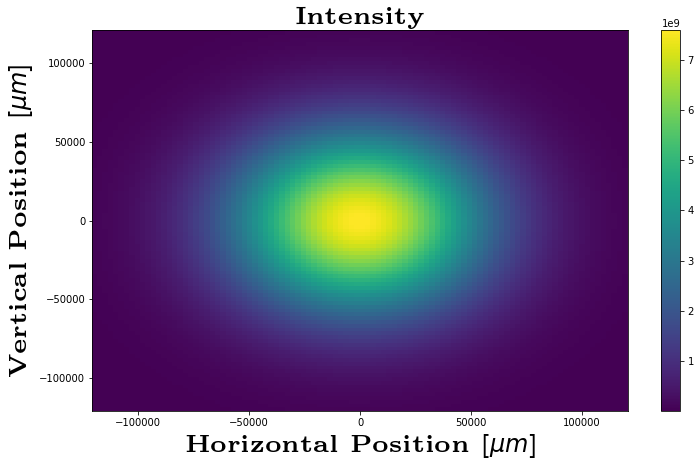

In [9]:
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), int0_2d, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

# ax.set_ylim(-1e4,1e4)
# ax.set_xlim(-1e4,1e4)
ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_title('Intensity',**hfontLarge)

Text(0.5, 1.0, 'Phase')

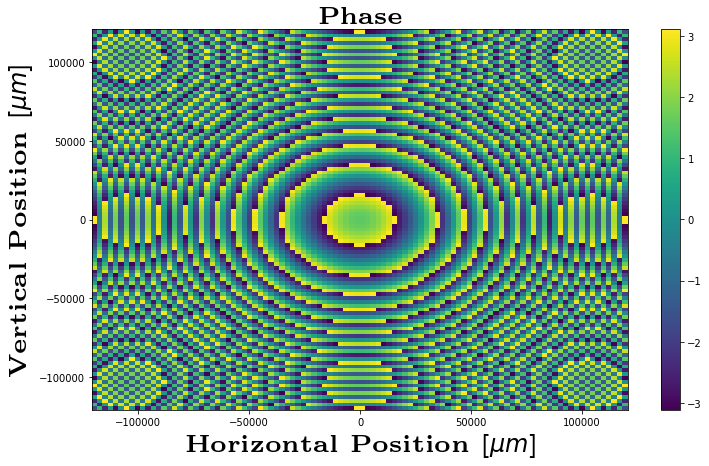

In [10]:
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), phase0_2d, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

# ax.set_ylim(-1e4, 1e4)
# ax.set_xlim(-1e4, 1e4)
ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_title('Phase',**hfontLarge)

Text(0.5, 1.0, 'Re(E)')

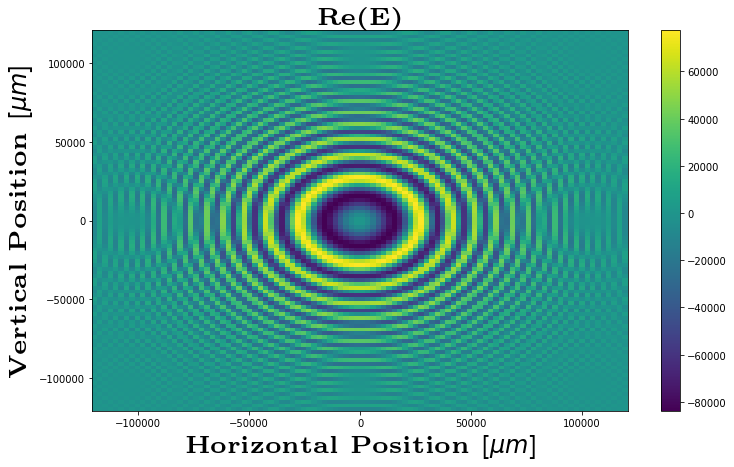

In [11]:
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), re0_2d, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

# ax.set_ylim(-1e4, 1e4)
# ax.set_xlim(-1e4, 1e4)
ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_title('Re(E)',**hfontLarge)

Text(0.5, 1.0, 'Im(E)')

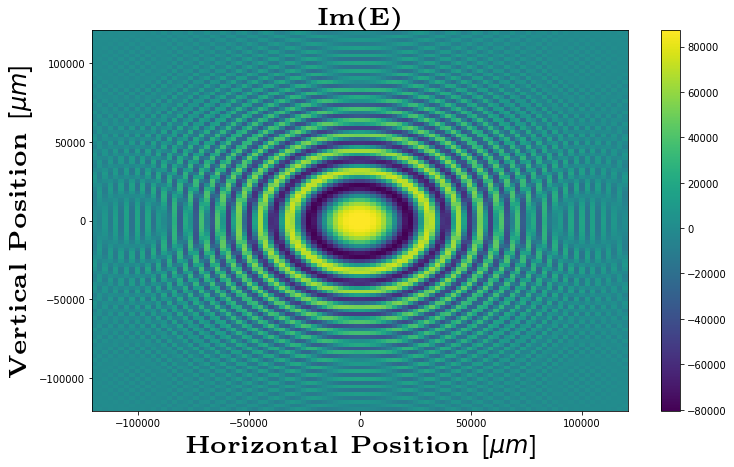

In [12]:
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), im0_2d, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

# ax.set_ylim(-1e4, 1e4)
# ax.set_xlim(-1e4, 1e4)
ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_title('Im(E)',**hfontLarge)

##### Extract Re and Im fields via CalcIntFromElecField

In [ ]:
#Plot initial wavefront
##Initial wfr calculation
arIinit = srwlib.array('f', [0]*wfr0.mesh.nx*wfr0.mesh.ny) #"flat" array to take 2D intensity data
re0 = srwlib.array('f', [0]*wfr0.mesh.nx*wfr0.mesh.ny) # "flat" array to take 2D Re(E) data
im0 = srwlib.array('f', [0]*wfr0.mesh.nx*wfr0.mesh.ny) # "flat" array to take 2D Im(E) data
srwl.CalcIntFromElecField(arIinit, wfr0, 6, 0, 3, wfr0.mesh.eStart, 0, 0) #extracts intensity
srwl.CalcIntFromElecField(re0, wfr0, 6, 5, 3, wfr0.mesh.eStart, 0, 0) #extracts Re(E)
srwl.CalcIntFromElecField(im0, wfr0, 6, 6, 3, wfr0.mesh.eStart, 0, 0) #extracts Im(E)
##Reshaping electric field data from flat to 2D array
arIinit2D = np.array(arIinit).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
re_2d_0 = np.array(re0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
im_2d_0 = np.array(im0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
# wfrsizei=np.size(arIinit)

print('Size of initial wavefront data array (coordinate):',np.shape(arIinit2D))
xvalsf02=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
yvalsf02=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

fig = plt.figure(figsize=(12,7))
ax = fig.gca()

# By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arIinit2D, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

ax.set_ylim(-1e4,1e4)
ax.set_xlim(-1e4,1e4)
ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_title('Intensity at Waist',**hfontLarge)

In [ ]:
# plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), re_2d_0, cmap=plt.cm.viridis, shading='auto')
plt.pcolormesh(np.multiply(xvalsf02,1), np.multiply(yvalsf02,1), re_2d_0, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

# ax.set_ylim(-1e3,1e3)
# ax.set_xlim(-1e3,1e3)
ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_title('Re(E) at Waist',**hfontLarge)

In [ ]:
plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), im_2d_0, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_ylim(-1,1)
ax.set_xlim(-1,1)
ax.set_title('Im(E) at Waist',**hfontLarge)

In [ ]:
#Export initial wavefront to file
fname="InitialWavefrontArray.txt"
np.shape(arIinit2D)
np.savetxt(fname, arIinit2D, fmt='%.18e')

In [ ]:
##Construct 1:1 beamline in SRW and propagate Gaussian through it
##Parameters for 1 to 1 focusing beamline creation, createBL1to1(L,dfof)
#L: total path length
#dfof: focal length variation factor (=0 for no variation; can be positive or negative)
L=15.  ##Drift length before and after lens

wfr1 = deepcopy(wfr0)
#srwl.ResizeElecField(wfr1, 'c', [1, 5, 15, 5, 15])

wfrsizef=(wfr1.mesh.nx*wfr1.mesh.ny)

optBL1to1 = wavefront.createBL1to1(L,dfof=0)
start_time = time.time()
srwl.PropagElecField(wfr1, optBL1to1)
print("Propagation time: %s seconds" %(round((time.time() - start_time),5)))

In [ ]:
#Extract final array and export to numpy array
arIf = srwlib.array('f', [0]*wfr1.mesh.nx*wfr1.mesh.ny) #"flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIf, wfr1, 6, 0, 3, wfr1.mesh.eStart, 0, 0) #extracts intensity
##Reshaping electric field data from flat to 2D array
arIf2D = np.array(arIf).reshape((wfr1.mesh.nx, wfr1.mesh.ny), order='C')

xvalsf02=np.linspace(wfr1.mesh.xStart,wfr1.mesh.xFin,wfr1.mesh.nx)
yvalsf02=np.linspace(wfr1.mesh.yStart,wfr1.mesh.yFin,wfr1.mesh.ny)

fig = plt.figure(figsize=(12,7))
ax = fig.gca()

# By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arIf2D, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

ax.set_ylim(-1e4,1e4)
ax.set_xlim(-1e4,1e4)
ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_title('Intensity after propagation',**hfontLarge)